## Value Iteration

In the next section of the notebook, we will be looking at convergence rates of Value Iteration methods. In particular, we will be demonstrating Gauss-Seidel, Jacobi, Gauss-Seidel-Jacobi, and Prioritized Sweeping variations on plain Value Iteration.

Various resources that can help with the understanding of these methods can be found here:

Prioritized sweeping:

http://webdocs.cs.ualberta.ca/~sutton/book/ebook/node98.html
http://ipvs.informatik.uni-stuttgart.de/mlr/wp-content/uploads/2016/04/02-MarkovDecisionProcess.pdf
http://www.jmlr.org/papers/volume6/wingate05a/wingate05a.pdf

Jacobi:

https://tspace.library.utoronto.ca/bitstream/1807/24381/6/Shlakhter_Oleksandr_201003_PhD_thesis.pdf

Gauss-Seidel

http://ipvs.informatik.uni-stuttgart.de/mlr/wp-content/uploads/2016/04/02-MarkovDecisionProcess.pdf

In addition sections 6.3 of Puterman (1994) and the Sutton Reinforcement Learning text have detailed descriptions of theoretical methods.

To better understand Value Iteration, let's generate the optimal Value functions and policies and compare how fast each method converges!


In [2]:
from mdp_matrix import GridWorld
from value_iteration_matrix import ValueIteration, GaussSeidelValueIteration, JacobiValueIteration, PrioritizedSweepingValueIteration, GaussSeidelJacobiValueIteration
from policy_iteration import policy_iteration, modified_policy_iteration, policy_iteration_by_inversion
import matplotlib.pyplot as plt
import numpy as np
import pprint
from operator import itemgetter
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import Latex

## Grid world
We set up a grid world MDP similar to the one shown on Sutton page 82

In [3]:
Image(url= "https://webdocs.cs.ualberta.ca/~sutton/book/ebook/figtmp15.png")

In [13]:
test_rewards = [[i, j, -1] for i in range(5) for j in range(5)]
test_rewards[2] = [0, 2, 1]
test_rewards[23] = [4,3,1]

# Instantiate the gridworld
gw = GridWorld(5, test_rewards)
pprint.pprint(np.reshape(gw.R, (5,5)))

array([[-1., -1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1.]])


First run to optimal value at epsilon 0.001....
||V1 - V0|| = 4.500000
Converged in 1675 iterations (67 sweeps)
Now evaluating policies...

Value Iteration
||V1 - V0|| = 4.500000
Converged in 1125 iterations (45 sweeps)

GS
||V1 - V0|| = 3.855664
Converged in 1125 iterations (45 sweeps)

J
Converged in 150 iterations (6 sweeps)

GSJ
Converged in 150 iterations (6 sweeps)

PS
Converged in 1189 iterations


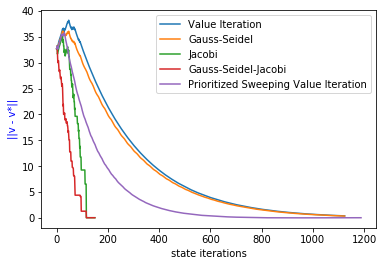

In [5]:
%matplotlib inline

vl = ValueIteration(gw)

print("First run to optimal value at epsilon 0.001....")
optimal_policy, optimal_value, _  = vl.run()

print("Now evaluating policies...\n")

print("Value Iteration")
optimal_policy, v, vs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vs)

print("\nGS")

vl = GaussSeidelValueIteration(gw)

optimal_policy, v, vsgs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsgs)

print("\nJ")
vl = JacobiValueIteration(gw)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

print("\nGSJ")
vl = GaussSeidelJacobiValueIteration(gw)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

print("\nPS")
vl = PrioritizedSweepingValueIteration(gw)
optimal_policy, v, vsps = vl.run(optimal_value=optimal_value)
plt.plot(vsps)

plt.xlabel('state iterations')
plt.ylabel('||v - v*||',color='b')

plt.legend(['Value Iteration', 'Gauss-Seidel', 'Jacobi', 'Gauss-Seidel-Jacobi', 'Prioritized Sweeping Value Iteration'], loc='upper right')

plt.show()



## What just ran?

As you can see from the above, we found the optimal policies and value functions for a simple GridWorld problem.

As you can see, Gauss-Seidel-Jacobi and Jacobi splitting methods appear to perform the best in practice, quickly dropping to the optimal Value function.

## What about the theory?

### Value Iteration
Formally, Value Iteration requires an infinite amount of steps to converge to V*.

See https://webdocs.cs.ualberta.ca/~sutton/book/4/node5.html

However, according to Puterman (1994), we can approximate the number of additional iterations required to produce a value function within some epsilon error of optimal.

From page 164 of Puterman, 6.3.8, here lambda = .9, and from above ||v1 - v0|| = 4.500000 and epsilon = .01

Then $.01 \le \frac{2*.9^n}{1-.9}*4.5$ and solving for n yields: 86 (sweeps). Here we use v1-v0 to be the difference between the first and second sweep. 

As you can see, in practice on a small grid, value iteration only requires 45 sweeps.


### Gauss-Seidel 

For Gauss-Seidel iteration estimation, we follow Puterman p.171

We need to find $\sigma(Q^{-1}R) \le \alpha$. That is whe need to find the spectral radius of the QR decomposition of the transition matrix. This provides us with an estimate for the number of iterations to converge to optimal as in Value Iteration above, instead of using the discount factor.


In [37]:
import numpy
import scipy.linalg

max_alpha = None
for a in range(gw.A):
    L, U = numpy.tril(gw.T[:,a,:], k=-1), numpy.triu(gw.T[:,a,:])
#     print(numpy.diag(L))

    Q = np.eye(gw.S) - .9*L
    R = .9*U
#     print(numpy.linalg.inv(Q).dot(R))
    w = numpy.linalg.eigvals(numpy.linalg.inv(Q).dot(R))
#     print(w)
#     print(V)
    alpha = max(w)
    if not max_alpha or alpha > max_alpha:
        max_alpha = alpha

print(max_alpha)
    

0.9


So in our example, actually the $\alpha$ value is equivalent to the $\gamma$ discount factor. Hence, by Puterman (1994) p.171, we find that Value Iteration and Gauss-Seidel will converge in the same number of iterations.

In practice, we see that this is true, but Gauss-Seidel converges at a slightly faster right at the beginning.


### Jacobi

In Jacobi value iteration, the decomposition for finding $\alpha$ is slightly different. See page 172 of Puterman. Loosely, we know that Jacobi will outperform Value Iteration in convergence iterations when all the values of the diagonal in the Transition matrix are > 0. More specifically, we decompose the transition matrix into $Q, R$ as per Puterman p.172.



In [ ]:
import numpy
import scipy.linalg

max_alpha = None
for a in range(gw.A):
    copy = gw.T[:,a,:].copy()
    np.fill_diagonal(copy, 0.)
    R, Q = .9*copy, numpy.diag(1. - .9*numpy.diag(gw.T[:,a,:]))
    QRinv = numpy.linalg.inv(Q).dot(R)
    
    w = numpy.linalg.eigvals(QRinv)
    alpha = max(w)
    if not max_alpha or alpha > max_alpha:
        max_alpha = alpha

print(max_alpha)

### Prioritized Sweep



## Policy Iteration
We'll now run policy iteration on the same gridworld MDP in three ways:
- Policy iteration using value iteration
- Policy iteration using matrix inversion
- Modified policy iteration (Puterman section 6.5)


- Policy iteration by matrix inversion evaluates the policy using the following closed form expression:

In [52]:
%%latex
\begin{align} 
V &=PR + \gamma PV\\
\Leftrightarrow (I-\gamma P) V &= PR\\
\Rightarrow V &= (I-\gamma P)^{-1} PR 
\end{align}

<IPython.core.display.Latex object>

- And the modified policy iteration algorithm presented in Puterman starts with a round of policy improvement and then does policy evaluation m times, before going back to policy improvement...etc.

Converged in 5 iterations, 96 evaluations
Converged in 4 iterations, 4 evaluations
Converged in 4 iterations, 20 evaluations


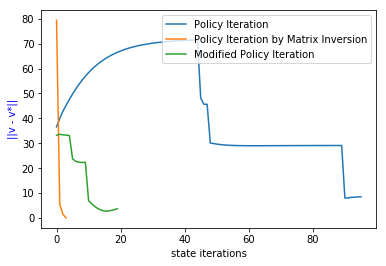

In [6]:
%matplotlib inline
epsilon = 0.01
gamma = 0.9

m = 5

V_pi, pol_pi, n_iter_pi, vs_pi = policy_iteration(gw, gamma, epsilon, optimal_value)
plt.plot(vs_pi)

V_inv, pol_inv, n_iter_inv, vs_inv = policy_iteration_by_inversion(gw, gamma, optimal_value)
plt.plot(vs_inv)

V_modpi, pol_modpi, n_itermodpi, vs_modpi = modified_policy_iteration(gw, gamma, epsilon, m, optimal_value)
plt.plot(vs_modpi)

plt.xlabel('state iterations')
plt.ylabel('||v - v*||',color='b')

plt.legend(['Policy Iteration', 'Policy Iteration by Matrix Inversion', 'Modified Policy Iteration'], loc='upper right')

plt.show()

Notice the initial ramp up in error for policy iteration. This is due to the initial policy evaluation taking a long time to reach convergence. Once it reaches that comes in policy improvement which then starts driving down the error.

Modified policy iteration doesn't have this initial ramp up as it starts off with policy improvement directly.

And policy iteration by matrix inversion doesn't take many iterations because it evaluates policies non-iteratively. However it does involve a matrix inverse.

## VI vs PI
Now we'll compare both approaches in terms of iterations over state values.
Let's start by making a larger gridworld MDP

In [20]:
dim = 25
test_rewards_2 = [[i, j, -1] for i in range(dim) for j in range(dim)]
test_rewards_2[0] = [0, 0, 1]
test_rewards_2[624] = [24, 24 ,1]

# Instantiate the gridworld
gw2 = GridWorld(dim, test_rewards)

Converged in 41875 iterations (67 sweeps)
Converged in 28125 iterations (45 sweeps)
Converged in 28125 iterations (45 sweeps)
Converged in 30000 iterations (48 sweeps)
Converged in 12500 iterations (20 sweeps)
Converged in 1999 iterations


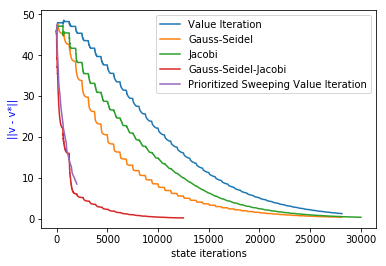

In [21]:
%matplotlib inline

vl = ValueIteration(gw2)

optimal_policy, optimal_value, _  = vl.run()
optimal_policy, v, vs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vs)

vl = GaussSeidelValueIteration(gw2)

optimal_policy, v, vsgs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsgs)

vl = JacobiValueIteration(gw2)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

vl = GaussSeidelJacobiValueIteration(gw2)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

vl = PrioritizedSweepingValueIteration(gw2)
optimal_policy, v, vsps = vl.run(optimal_value=optimal_value)
plt.plot(vsps)

plt.xlabel('state iterations')
plt.ylabel('||v - v*||',color='b')

plt.legend(['Value Iteration', 'Gauss-Seidel', 'Jacobi', 'Gauss-Seidel-Jacobi', 'Prioritized Sweeping Value Iteration'], loc='upper right')

plt.show()
